# Processing Temperature data from MICC
## INPUTS - pressure and temperature data files (.txt)
## OUTPUTS: adiabatic temperature, exponential fit to temperature, plot 

To use: 
1. enter file names of pressure and temperature files into the first cell below
2. run Cells 1 - 3
3. enter the start and end time of an expansion into first line of Cell 4
4. run Cell 4, NOTE: plot saved to current directory as a "expansion_start_time".pdf
5. for further expansions repeat steps 3 and 4

### Cell 1

In [6]:
# INPUTS - location of pressure and temperature files

# Pressure file path
Pressure_file_1 = './Pressure/140403/03041124.txt'      # First pressure file
Pressure_file_list = ['./Pressure/140403/03041545.txt', # Subsequent pressure files
                      './Pressure/140407/07041119.txt'  # must be in time sequential order
                     ] 

# Temperature file path
Temperature_file_1 = './Therocouple/140403/140403_tep.txt' # First temperature file
Temperature_file_list = ['./Therocouple/140407/140407_1128.txt'] # Subsequent temperature files

# NOTE: if only one Pressure or Temperature file then
# Pressure_file_list = []    # empty list
# Temperature_file_list = [] # empty list


### Cell 2

In [7]:
# read in temperature and pressure chamber data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.optimize import curve_fit
import math

# read in pressure data
Pressure = pd.read_csv(Pressure_file_1, skiprows=1,sep='\t') 

# read in and append pressure data from Pressure_file_list
for i in Pressure_file_list:
    P = pd.read_csv(i,skiprows=1,sep='\t')
    Pressure = Pressure.append(P)

Pressure['datetime'] = Pressure['Date'] + ' ' + Pressure['Time'] # create datetime column
Pressure['datetime'] = [dt.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for x in Pressure['datetime']]

# read in Temperature data
Temperature = pd.read_csv(Temperature_file_1, skiprows=2, sep='\t')

# read in and append temperature data from Temperature_file_list
for i in Temperature_file_list:
    T = pd.read_csv(i, skiprows=2,sep='\t')
    Temperature = Temperature.append(T)

Temperature.columns = ['date','time','1','2','3','4','5','6','7','8','unknown'] # name columns
Temperature['datetime'] = Temperature['date'] + ' ' + Temperature['time']       # create datetime column
Temperature['datetime'] = [dt.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for x in Temperature['datetime']]

# find thermocouple with lowest temperature
minT = Temperature[['1','2','3','4','5','6','7','8']].sum().idxmin() # minT is an index to the therocouple
                                                                     # with the lowest total temperature
# combine temperature and pressure data for the same times into one dataframe
P = pd.DataFrame() # create empty
T = pd.DataFrame() # dataframes

P['Pressure'] = Pressure['Pressure (mBar)']        # fill empty dataframes
T['Temperature'] = Temperature[minT] + 273.15      # use lowest thermocouple data (minT)

P.index = Pressure['datetime']  # index dataframes with datetime
T.index = Temperature['datetime']

# join T and P together depending on which is the longest to avoid overlap
if len(T) > len(P):
    result = T.join(P, how = 'inner')
else:
    result = P.join(T, how = 'inner')

result['adiabatic'] = 0.0 # create empty columns 
result['Temp_corr'] = 0.0 # to be filled later
result['fit']       = 0.0 #
    
result.head()



,Temperature,Pressure,adiabatic,Temp_corr,fit
datetime,,,,,
2014-04-03 11:24:53,247.33,NaN,0.0,0.0,0.0
2014-04-03 11:24:56,247.34,1023.4945,0.0,0.0,0.0
2014-04-03 11:24:57,247.33,1023.5057,0.0,0.0,0.0
2014-04-03 11:24:58,247.32,1023.3395,0.0,0.0,0.0
2014-04-03 11:24:59,247.32,1023.3551,0.0,0.0,0.0


## Define some functions

### Cell 3

In [8]:
def firstNonNan(listfloats):
    """ function that returns first non nan value in list 
    """
    for item in listfloats:
        if math.isnan(item) == False:
            return item

def Temp_correct(Press, Temp):
    """ Function that calculates adiabatic temperaure change from pressure 
        and calculates corrected temperature data using a time consant
        
        Press is a list of pressure values
        
        Temp is a list of temperature values in Kelvin, its helpful to smooth the data before
        passing to this function
    """
    
    gamma = 287.058/1005.0
    P0 = Press[0]
    T0 = firstNonNan(Temp)
    alpha = (1/60)
    
    adiabatic = np.zeros(len(Press)) # create empty array for calculation of adiabatic T
    Delta = np.zeros_like(adiabatic)
    Delta[0] = T0

    for i in range(0,len(Press)):
        adiabatic[i] = T0*(Press[i]/P0)**(gamma)
        if i == 0:
            Delta[i] = Temp[i]
        else:
            Delta[i] = Temp[i]-Temp[i-1]
            
    T_corr = Delta/alpha + Temp
    T_corr[0] = Temp[0]
    
    return T_corr, adiabatic

def temp_func(x, A, tau, d):
    return (d+A*np.exp(-tau*x))

def fit_temp(ydata):

    xdata = list(range(len(ydata)))
    ydata = ydata.rolling(8).mean()
    ydata = np.where(ydata is np.inf, np.nan, ydata) # replace infs with NaNs

    # replace NaNs with closest value
    ind = np.where(~np.isnan(ydata))[0]
    first, last = ind[0], ind[-1]
    ydata[:first] = ydata[first]
    ydata[last + 1:] = ydata[last]

    # Find exponetial curve that fits corrected temperature data
    # only use temperature data towards the begining of expansion for fitting
    popt, pcov = curve_fit(temp_func, xdata[10:150], ydata[10:150], p0=(1, 1e-6, T0))
    
    # use fitted values to calculated 'test' fitted temperature curve
    fit_t = [temp_func(x, popt[0], popt[1], popt[2]) for x in xdata] 
    
    return fit_t, popt


## Calculation of corrected temperature and fit parameters

### Cell 4

fit parameter 1 =  7.13421654355
fit parameter 2 =  0.0333273438929


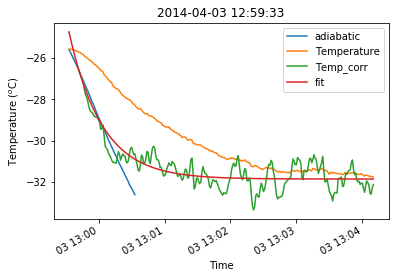

In [9]:
# Inputs - start and end time of expansions:

start = '2014-04-03 12:59:33'
end = '2014-04-03 13:04:10'

# create index value for one minute after start 
end2 = pd.Timestamp(start) + pd.Timedelta(minutes=1)

# create lists of pressure and temperature values
# to be used to calculate the adiabatic temperature
# and time constant corrected temperature
Pressure2 = result['Pressure'][start:end]
Temp = result['Temperature'][start:end].rolling(8).mean()

# define starting temperature
T0 = firstNonNan(Temp)

# Call Temp_correct function to calculate adiabatic temperature and time constant 
# corrected temperature and write result to dataframe result
result['Temp_corr'][start:end], result['adiabatic'][start:end] = Temp_correct(Pressure2, Temp) 

# Call fit_temp to find exponential fit to corrected temperature
# and calculated fitted profile
result['fit'][start:end], fit_params = fit_temp(result['Temp_corr'][start:end])

print('fit parameter 1 = ',fit_params[0])
print('fit parameter 2 = ',fit_params[1])

# plotting everything out
plt.plot(result['adiabatic'][start:end2]-273.15)
plt.plot(result['Temperature'][start:end]-273.15)
plt.plot(result['Temp_corr'][start:end].rolling(2).mean()-273.15)
plt.plot(result['fit'][start:end]-273.15)

plt.legend()
plt.gcf().autofmt_xdate()
plt.xlabel('Time')
plt.ylabel('Temperature ($^{o}$C)')
plt.title(start)
plt.savefig(start + '.pdf')
plt.show()
